In [724]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [725]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn

# Práctica 5: Introducción a Modelos de Clasificación

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Implemente una clase  que permita ajustar un modelo KNN. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.
- La clase debe permitir el uso de la distancia Mikownski y similitud coseno.

El algoritmo k-vecinos más cercanos (KNN) es un simple algoritmo de aprendizaje automático supervisado que se puede utilizar para resolver problemas de clasificación y regresión. Es fácil de implementar y comprender, pero tiene un inconveniente importante de volverse significativamente más lento a medida que crece el tamaño de los datos en uso.

KNN trabaja buscando las distancias entre una consulta y todos los ejemplos en los datos, seleccionando el número especificado ejemplos (K) más cercanos a la consulta, luego vota por la etiqueta más frecuente (en el caso de la clasificación) o promedia las etiquetas (en el caso de la regresión).

En el caso de la clasificación y la regresión, vimos esa elección la K correcta para nuestros datos se hace probando varios Ks y escogiendo el que mejor funciona.

In [726]:
import time
import numpy as np
from tqdm import tqdm

class KNNModel:

    def __init__(self, k=5, metric='euclidean' , p=2):
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        start_time = time.time()
        predictions = []
        for x_test in tqdm(X):
            distances = []
            for x_train in self.X_train:

                #identificamos el metodo de distancia a utilizar

                if self.metric == 'euclidean':
                    distance = np.sqrt(np.sum((x_test - x_train)**2))
                elif self.metric == 'cosine':
                    distance = 1 - (np.dot(x_test, x_train) / (np.linalg.norm(x_test) * np.linalg.norm(x_train)))
                elif self.metric == 'manhattan':
                    distance = np.sum(np.abs(x_test - x_train))
                elif self.metric == 'mikownski':
                    
                    distance = (np.sum((x_test - x_train)**self.p))**(1/self.p)
                else:
                    raise ValueError('Metrica no soportada')

                distances.append(distance)
            #evaluamos la distancia de cada punto con el resto de los puntos
            top_k_indices = np.argsort(distances)[:self.k]
            top_k_classes = [self.y_train[i] for i in top_k_indices]
            most_common_class = max(set(top_k_classes), key=top_k_classes.count)
            predictions.append(most_common_class)
        
        elapsed_time = time.time() - start_time
        print(f"Prediccion completada en {elapsed_time:.2f} segundos.")
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)


#### Prueba con un dataset de cancer

In [727]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

# Cargar datos de ejemplo
data = load_breast_cancer()
X, y = data.data, data.target

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar modelo KNN
model = KNNModel(k=5, metric='mikownski' , p=2)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la puntuación en el conjunto de prueba
score = model.score(X_test, y_test)

# Imprimir precisión
print(f"Precisión: {accuracy_score(y_test, y_pred):.4f}")


100%|██████████| 114/114 [00:00<00:00, 428.47it/s]


Prediccion completada en 0.27 segundos.


100%|██████████| 114/114 [00:00<00:00, 441.76it/s]

Prediccion completada en 0.26 segundos.
Precisión: 0.9474


## Asignación 2

Implemente una clase que permita ajustar un modelo Naive Bayes. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Cada método debe imprimir una barra de progreso que permita conocer el tiempo estimado en que terminará.

En esta sección se incluye un dataset real. El dataset importado se llama _spambase_ y puede leer su descripción en la siguiente liga

https://www.openml.org/d/42904

In [728]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(42904, download_data=False)

target = "CLASS"

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    _, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

columns = np.array(columns)

In [729]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")

La columna a predecir se llama 'CLASS'
Todas las características son ['COMMENT_ID' 'AUTHOR' 'DATE' 'CONTENT']


In [730]:
# Impresión de las características
features
# Eliminar las características que no se pueden utilizar para predecir
features = features.drop(columns=["COMMENT_ID", "AUTHOR", "DATE"])

In [731]:
features

,CONTENT
0,"Huh, anyway check out this you[tube] channel: ..."
1,Hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿
...,...
345,How can this have 2 billion views when there's...
346,I don't now why I'm watching this in 2014﻿
347,subscribe to me for call of duty vids and give...
348,hi guys please my android photo editor downloa...


In [732]:
import sys

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
        file.write("\n")
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
        file.write("\n")
    file.flush()

In [733]:
import time
import numpy as np
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.mean = None
        self.var = None
    def fit(self, X, y):
        start_time = time.time()
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        # Calcular priori de clase
        for i, c in enumerate(self.classes):
            self.class_priors[i] = np.sum(y == c) / len(y)
        # Calcular media y varianza de cada clase
        for i in progressbar(range(len(self.classes)), "Procesando: ", 40):
            for i, c in enumerate(self.classes):
                X_c = X[y == c]
                self.mean[i] = X_c.mean(axis=0)
                self.var[i] = X_c.var(axis=0)
        elapsed_time = time.time() - start_time
        print(f"Entrenamiento completado en {elapsed_time:.2f} segundos.")
    #La función predict es un método de la clase NaiveBayes, que toma como entrada una matriz X de puntos de datos y devuelve
    #una matriz predictions de etiquetas de clase predichas correspondientes a cada punto de datos en X.
    def predict(self, X):
        # almacena el tiempo de inicio de la predicción.
        start_time = time.time()
        # lista vacía para almacenar las etiquetas de clase predichas.
        predictions = []
        for x in X:
            for i in progressbar((X), "Procesando: ", 40):
                class_probs = []
                for i, c in enumerate(self.classes):
                    #:calcula el logaritmo de la probabilidad a priori de la clase i.
                    prior = np.log(self.class_priors[i])
                    posterior = np.sum(np.log(self.normal_pdf(x, self.mean[i], self.var[i])))
                    class_prob = prior + posterior
                    class_probs.append(class_prob)
                predictions.append(self.classes[np.argmax(class_probs)])
        elapsed_time = time.time() - start_time
        print(f"Prediccion completada en  {elapsed_time:.2f} segundos.")
        return np.array(predictions)
    #La función devuelve el valor de la función de densidad de probabilidad en x.
    def normal_pdf(self, x, mean, var):
        eps = 1e-4
        numerator = np.exp(-0.5 * (x - mean)**2 / (var + eps))
        denominator = np.sqrt(2 * np.pi * var + eps)
        return numerator / denominator

## Asignación 3

Realice el preprocesamiento que considere adecuado para que el dataset pueda ser procesado por un modelo de clasificación. __No olvide utilizar particionar en entrenamiento y validación, y realizar el preprocesamiento de manera adecuada__.

In [734]:
#unir en un solo dataframe las caracteristicas y la columna a predecir
data = pd.concat([features, outputs], axis=1)

In [735]:
import pandas as pd
import numpy as np
import re
import nltk

# Separa los comentarios y etiquetas en dos arrays diferentes

comentarios = data['CONTENT']
etiquetas = data['CLASS']

def preprocesar_comentarios(comentarios):
    # Elimina caracteres no deseados
    comentarios = comentarios.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    # Convierte a minúsculas
    comentarios = comentarios.apply(lambda x: x.lower())
    # Elimina stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    comentarios = comentarios.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # Lematiza palabras
    lemmatizer = nltk.WordNetLemmatizer()
    comentarios = comentarios.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    return comentarios

comentarios = preprocesar_comentarios(comentarios)
#concatener comentarios + etiquetas en un solo dataframe
data = pd.concat([comentarios, etiquetas], axis=1)
print(data)


                                               CONTENT  CLASS
0          huh anyway check youtube channel kobyoshi02      1
1    hey guy check new channel first vid u monkey i...      1
2                                   test say murdevcom      1
3                      shaking sexy as channel enjoy _      1
4                              watchvvtarggvgtwq check      1
..                                                 ...    ...
345                    2 billion view there planet lol      0
346                              dont im watching 2014      0
347    subscribe call duty vids give aways goal100 sub      1
348  hi guy please android photo editor download th...      1
349  first billion viewed thought really cool billi...      0

[350 rows x 2 columns]


## Asignación 4

Realice una visualización de los datos en dos dimensiones. Posteriormente entrene un modelo de KNN (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

In [736]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [737]:
def etiquetar_documentos(docs):
    return [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(docs)]

# Función para entrenar el modelo Doc2Vec
def entrenar_doc2vec(docs):
    docs_etiquetados = etiquetar_documentos(docs)
    modelo = Doc2Vec(vector_size=400, min_count=7, epochs=80)
    modelo.build_vocab(docs_etiquetados)
    modelo.train(docs_etiquetados, total_examples=modelo.corpus_count, epochs=modelo.epochs)
    return modelo

modelo_doc2vec = entrenar_doc2vec(comentarios)
def preprocesar_comentario(comentario):
    tokens = word_tokenize(comentario.lower())
    return modelo_doc2vec.infer_vector(tokens)

#prepro
comentarios_preprocesados = [preprocesar_comentario(comentario) for comentario in comentarios]

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(comentarios_preprocesados, etiquetas, test_size=0.2, random_state=42)

In [738]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
model = KNeighborsClassifier(n_neighbors=5, metric='cosine', p=2)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Compute the accuracy score on the test set
score = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Precisión: {score:.4f}")

Precisión: 0.7429


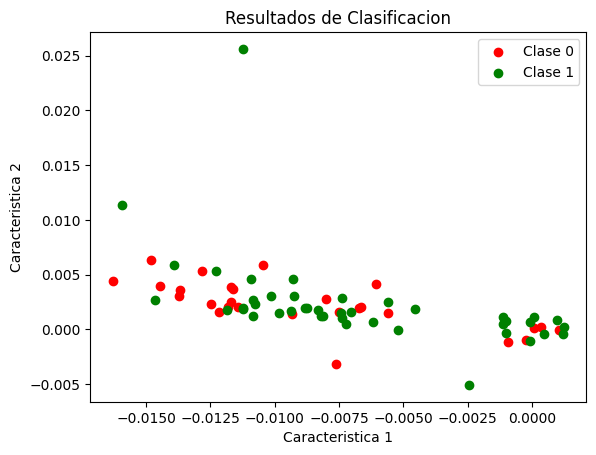

In [739]:
import matplotlib.pyplot as plt
import numpy as np

# Convert X_test to a NumPy array
X_test = np.array(X_test)

# Create a scatter plot of the test data
fig, ax = plt.subplots()
for label, color in zip(np.unique(y_test), ['red', 'green', 'blue']):
    idx = np.array(y_test == label)
    ax.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=f"Clase {label}")
ax.legend()
ax.set_xlabel("Caracteristica 1")
ax.set_ylabel("Caracteristica 2")
ax.set_title("Resultados de Clasificacion")
plt.show()


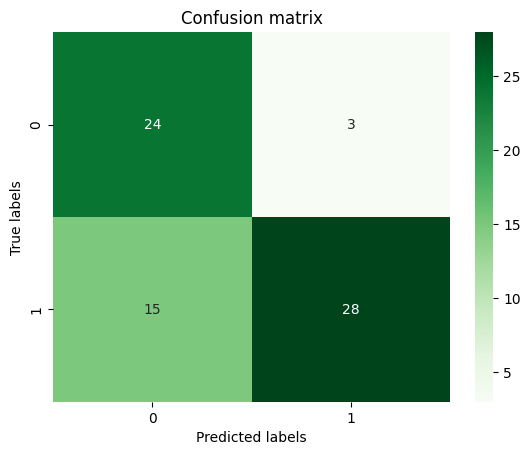

In [740]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix')
plt.show()


In [741]:
# Preprocess the new comments
new_comments = [
    "i hate this video",
    "pls contact me 55489701 free bitcoin",
    "check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y",
    "sub me pls and i will sub you back",
]
new_comments_preprocessed = [preprocesar_comentario(comentario) for comentario in new_comments]

# Make predictions on the new comments
predictions = model.predict(new_comments_preprocessed)
print("Prediccion de Bayes")
# Print the predicted labels
for comment, prediction in zip(new_comments, predictions):
    if prediction == 1:
        print(f"Este comentario: {comment} Es spam \n")
    else:
        print(f"Este comentario:: {comment} No es spam \n")


Prediccion de Bayes
Este comentario:: i hate this video No es spam 

Este comentario: pls contact me 55489701 free bitcoin Es spam 

Este comentario:: check this channel https://www.youtube.com/watch?v=Ndslxwl9N-Y No es spam 

Este comentario: sub me pls and i will sub you back Es spam 



## Asignación 5

Entrene un modelo de Naive Bayes (utilizando la clase implementada anteriormente) y valide que su modelo generaliza bien.

In [742]:

# Crea una instancia de la clase NaiveBayes
modelo = NaiveBayes()
# Convierte los datos de entrenamiento a arrays NumPy
X_train = np.array(X_train)
y_train = np.array(y_train)
# Entrena el modelo utilizando los datos de entrenamiento
modelo.fit(X_train, y_train)

Procesando: [........................................] 0/2
Procesando: [####################....................] 1/2

Procesando: [########################################] 2/2

Entrenamiento completado en 0.00 segundos.


In [743]:
comentarios = [
    "I love this song",
    "Sub me now for free Android games, apps",
    "Check my channel https://www.facebook.com/FUDAIRYQUEEN?pnref=story pls owo",
    "Song name??",
    "i hate this music. fucking singer and every koean chainise ana US sucks me dick.",
    "https://www.facebook.com/FUDAIRYQUEEN?pnref=story",
    "subscribe to me for call of duty vids and give aways Goal-100 subs﻿",
    "WORLD RECORD YOUTUBE VIDEO VIEWS"]

In [744]:
# Predice si un nuevo comentario es spam o no
from IPython.display import Markdown    
resultados = []
for com in comentarios:
    nuevo_comentario_preprocesado = preprocesar_comentario(com)
    es_spam = modelo.predict([nuevo_comentario_preprocesado])
    # Muestra si el nuevo comentario es spam o no
    if es_spam[0] == 1:
        print(com)
        print("El comentario es spam.")
        print(" ")
    else:
        print(com)
        print("El comentario no es spam.")
        print(" ")

Procesando: [........................................] 0/1
Procesando: [########################################] 1/1

Prediccion completada en  0.00 segundos.
I love this song
El comentario no es spam.
 
Procesando: [........................................] 0/1
Procesando: [########################################] 1/1

Prediccion completada en  0.00 segundos.
Sub me now for free Android games, apps
El comentario no es spam.
 
Procesando: [........................................] 0/1
Procesando: [########################################] 1/1

Prediccion completada en  0.00 segundos.
Check my channel https://www.facebook.com/FUDAIRYQUEEN?pnref=story pls owo
El comentario no es spam.
 
Procesando: [........................................] 0/1
Procesando: [########################################] 1/1

Prediccion completada en  0.00 segundos.
Song name??
El comentario no es spam.
 
Procesando: [........................................] 0/1
Procesando: [################################

In [21]:
#!/bin/python3

import math
import os
import random
import re
import sys

#
# Complete the 'compareTriplets' function below.
#
# The function is expected to return an INTEGER_ARRAY.
# The function accepts following parameters:
#  1. INTEGER_ARRAY a
#  2. INTEGER_ARRAY b
#

def compareTriplets(a, b):
    # Write your code here
    
    print(a)
    print(b)
   
    result = []
    for x in range(3):
        print(a[x])
        print(b[x])



In [22]:
import math
import os
import random
import re
import sys

if __name__ == '__main__':
   

    a = list(map(int, input().rstrip().split()))

    b = list(map(int, input().rstrip().split()))

    result = compareTriplets(a, b)

    #print(' '.join(map(str, result)))
    #print(a)
  

[2, 3, 5]
[2, 3, 4]
2
2
3
3
